# TP : Résolution de l'équation de Vlasov-Poisson 1D-1D par une méthode semi-lagrangienne

In [2]:
# Basic imports 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

On s'intéresse à l'équation de Vlasov  (évolution de la distribution des électrons dans un plasma) couplée avec l'équation de Poisson (évolution du champ électrique) 

\begin{equation}
\begin{cases}
\partial_t f + v \,\partial_x f - E(x,t) \,\partial_v f = 0 \\ 
\\ 
\partial_x E = \rho(x,t) = 1 - \int f(x,v,t) \,dv 
\end{cases}
\end{equation} 


## Discrétisation de l'espace des phases 

On considère un espace des phases en deux dimensions (une d'espace et une de vitesse) $\Omega = ]-\pi, \pi[^2 \subset \mathbb{R}^2$ que l'on va discrétiser par une grille uniforme $\mathcal{M} = \{(x_i, v_j)\}_{i= 0\,, \cdots, \,n_x-1\,,\,j=0\,, \cdots,\, n_v-1, }\subset \Omega$ 

In [17]:
nx = 100; nv = 100
dx = 2*np.pi / (2*nx) ; dv =2*np.pi / (2*nv)
dt = 1e-2
L = np.pi   
x = np.linspace(-L, L, num=nx, dtype=float)## Discrétisation de l'espace des phases 
v = np.linspace(-L, L, num=nv, dtype=float)
xx, vv = np.meshgrid(x,v) 
T = 40 

## Condition initiale 

On se donne une condition initiale en distribution de particules $f_0(x,v)$ 

In [4]:
x0 = 0; v0 = 0 

In [5]:
f = lambda x, v : (1 / 2*np.pi)*np.exp(-0.5*((x-x0)**2+(v-v0)**2))


Text(0, 0.5, '$v$')

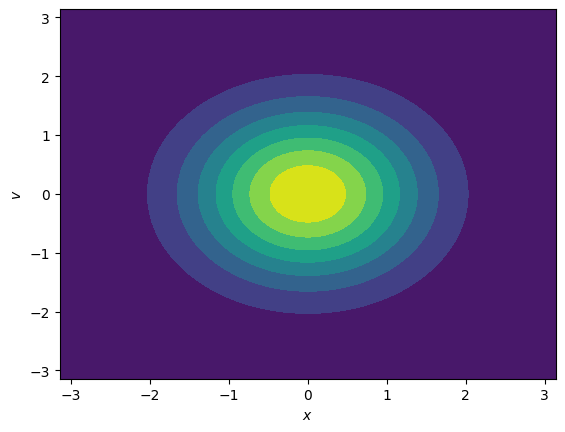

In [6]:
f_zero = f(xx, vv)
plt.contourf(x, v, f_zero)
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')  

On en déduit la densité de charge $\rho_0 (x) = 1 - \int f_0(x,v) \, \text{d}v$ 

In [7]:
np.shape(f_zero)

(100, 101)

In [8]:
print(nx, nv) 
print(np.shape(f_zero)[0])

101 100
100


In [9]:
rho_zero = np.zeros(nx) 
for i in range(nx): 
    rho_zero[i] = 1 - np.sum(f_zero[i])*dv

IndexError: index 100 is out of bounds for axis 0 with size 100

Text(0.5, 0, '$x$')

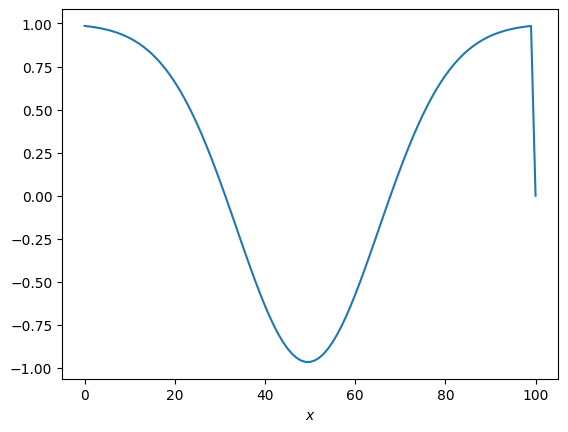

In [10]:
plt.plot(rho_zero)
plt.xlabel(r'$x$')

## Résolution de  l'équation de Poisson

La partie poisson du problème s'écrit 

\begin{equation}
\tag{P}
\partial_x E = \rho(x,t) = 1 - \int f(x, v, t) \,\text{d}v
\end{equation}

On va résoudre ce problème en discrétisant $f$ en modes de Fourier selon 
$$ f^n(x,v) = f(x,v, t_n) = \frac{1}{2\pi} \sum\limits_{k,l} c^n_{k,l} \, e^{i k.x} e^{i l.v} $$
Ainsi 
\begin{align*}
\rho^n(x, v) & = 1 - \frac{1}{2\pi} \sum\limits_{k,l} c^n_{k,l} \, e^{i k.x} \underbrace{\int e^{i l.v} \,\text{d}v}_{=0 \text{ si } l\neq 0 \text{ et } 2\pi \text{ sinon}} \\ 
             & = 1 - \sum\limits_{k} c^n_{k,0} \, e^{i k.x}  \\ 
             & = \sum\limits_{k} \tilde{c_k}^n \, e^{i k.x},         
\end{align*}
en posant $$\tilde{c_k}^n = 
            \begin{cases} 
                1 - c^n_{k,0} & \text { si } k=0 \\
                - c^n_{k,0} & \text{ sinon.}
            \end{cases} 
            $$
On écrit la somme de Fourier pour le champ électrique : 
$$ E^n(x) = \frac{1}{2\pi}\,\sum\limits_{j} d_j^n \, e^{i j.x} $$ 
donc 
$$ \frac{\text{d} E^n}{\text{d} x} = \frac{1}{2\pi}\,\sum\limits_{j} i j\, d_j^n \, e^{i j.x} $$

et par identification (unicité) des coefficients de Fourier on obtient $d_k^n = 2\pi\,\frac{\tilde{c_k}^n}{ik} \text{ pour } k\neq 0$. La valeur de $d_0^n$ qui correspond à la moyenne du champ électrique peut être choisie librement et on prendra par exemple $d_0^n=0$.

### Calcul des coefficients de Fourier de $f$

In [7]:
def fourier_coeff_2D(x, v, f):
    nx = len(x); nv=len(v)
    c_fft = np.fft.fft2(f) 
    c = ((4*np.pi**2) / (nx*nv)) * np.array(
        [np.exp(k*1j*np.pi)*np.exp(l*1j*np.pi) * c_fft[l,k]
        for l,k in np.ndindex((nv,nx))]
        )
    c.resize((nv,nx)) 
    return c

In [8]:
np.shape(np.fft.fft2(f_zero)) 

(100, 101)

In [11]:
c_zero = np.fft.fft2(f_zero)
c = fourier_coeff_2D(x, v, f_zero) 

In [12]:
np.shape(c)

(100, 101)

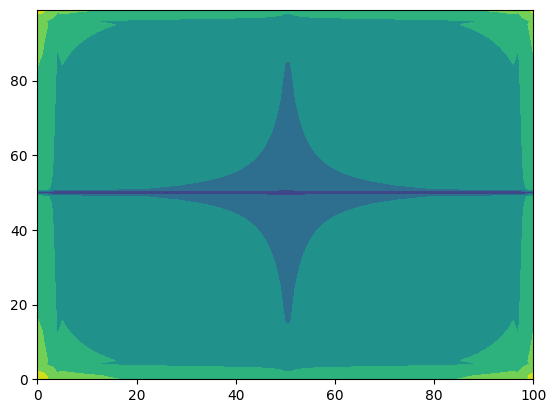

In [13]:
plt.contourf(np.log(np.abs(c)**2))

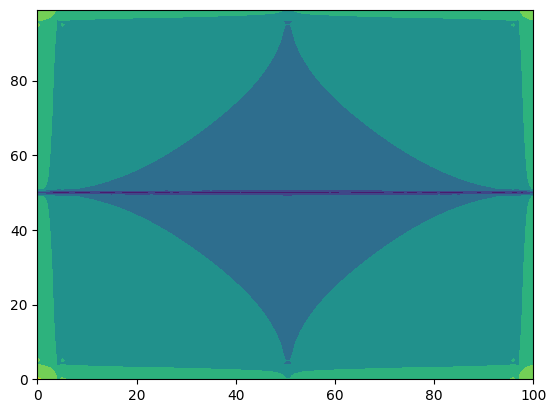

In [14]:
plt.contourf(np.log(np.abs(c_zero)**2))

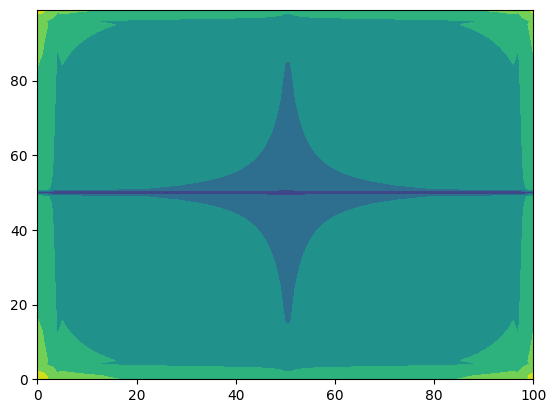

In [15]:
plt.contourf(np.log(np.abs(c)**2))

In [18]:
def fourier_reconstuction(x, k_values, c):
    s = lambda x: (1 / (2*np.pi)) * np.sum([coeff*np.exp(1j*k*x) for k, coeff in zip(k_values, c)])
    rec_arr = np.array(list(map(s, x))) 
    return rec_arr 

On écrit une fonction solve_poisson qui résout automatiquement l'équation de Poisson à $f$ donnée 

In [19]:
def solve_poisson(x, v, f):
    nx = len(x); nv = len(v) 
    c = fourier_coeff_2D(x, v, f)
    c_tilde = np.zeros(nx, dtype=complex)
    c_tilde[0] = 1 - c[0,0] 
    for i in range(1, nx):
        # 0-mode in v : c[O,:]
        c_tilde[i] = - c[0,i]        
    d = np.zeros(nx, dtype=complex)
    # Electric field mean has to be fixed, we choose 0 
    d[0] = 0 
    for k in range(1,nx):  
        d[k] = 2*np.pi *(c_tilde[k]) / (k*1j)
    _E = fourier_reconstuction(x, range(nx), d) 
    return _E
    

In [20]:
E = solve_poisson(x, v, f_zero) 

100


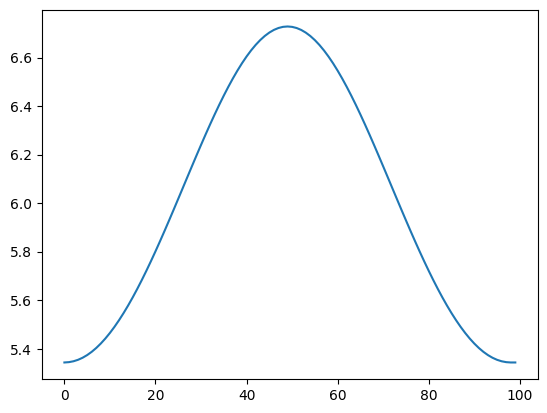

In [21]:
print(len(E))
plt.plot(np.abs(E))

## Transport dans l'équation de Vlasov


L'équation de Vlasov peut être décomposée en deux phénomènes décrivant son évolution :
- une advection en $v$ causée par le champ $E$ : 

\begin{equation}
\tag{a}
\partial_t f - E(x,t) \, \partial_v f = 0 
\end{equation}

- une advection en $x$ causée par le champ de vitesses : 

\begin{equation}
\tag{b}
\partial_t + v \,\partial_x f = 0
\end{equation}

Ces équations sont des équations de transport, dont les solutions analytiques peuvent être obtenues en appliquant la "méthode des caractéristiques".


### Méthode des caractéristiques



On considère une équation de transport 1D homogène à une dimension avec champ de vitesse $a(x,t)$: 

\begin{equation}
\tag{T}
\partial_t u + a(x,t)\,\partial_x u = 0
\end{equation}

Soit $(t,x) \in \mathbb{R}^{+} \times \mathbb{R}$ et  $X(s;t,x), s\in \mathbb{R}$ une courbe paramétrée lisse telle que $X(t;t,x) = x$.

On effectue le calcul de $\frac{d}{ds}u(X(s;t,x), t)$. 

\begin{align*} 
    \frac{\text{d}}{\text{d}s}u(X(s;t,x), s) = \partial_t u(X(s;t,x), s) + \frac{\text{d}X}{\text{d}s}(s;t,x)\, \partial_x u(X(s;t,x),s) & \quad \text{ (règle de la chaine)} 
\end{align*} 

On voit donc avec $(\text{T})$ que cette égalité se réduit à zéro si on impose la condition 

\begin{equation}
\tag{C}
\frac{\text{d}X}{\text{d}s} (s; t,x) = a(X(s;t,x),s) 
\end{equation}

On a ainsi réduit la résolution de l'EDP $(\text{T})$ à la résolution de l'EDO $(\text{C})$ dite "équation des caractéristiques". 


Dans le cas simple où le champ de vitesses $a$ est constant, l'équation $(\text{C})$ s'intégre en 
$$X(s;t,x) = as + b$$ 

et le coefficient b est déterminé par la condition

$$X(t;t,x) = x \implies b = x - at$$ 

de sorte que 

$$X(s;t,x) = x + a(s-t).$$

L'intérêt d'imposer l'équation des caractéristiques $\text{(C)}$ est de fixer 

$$\frac{\text{d}}{\text{d}s}u(X(s;t,x), s)= 0$$

et ainsi $\textbf{la solution est constante le long des courbes caractéristiques}$ de sorte que pour tout $(x,t)$

$$u(x,t) = u(X(t;t,x), t) = u(X(0;t,x), 0) = u_0(x-at)$$ 

où $u_0(x) = u(x, t=0)$ est la condition initiale. 



On voit ainsi ques les équations $(a)$ et $(b)$ sont analytiquement résolues par 

\begin{equation}
\tag{a*}
    f(x,v,t) = f_0(x, v + E(x)\,t)
\end{equation}
et
\begin{equation}
\tag{b*}
    f(x,v,t) = f_0(x - v\,t, v)
\end{equation}
respectivement. 

Seulement dans notre cas où l'on cherche à résoudre l'équation de Vlasov-Poisson (où l'évolution du champ électrique $E$ est couplée à l'équation de Vlasov) nous faison face à deux difficultés : 

1) Quel champ $E$ utiliser dans l'étape d'advection en $v$ ? Celui-ci évolue en effet simultanément par rapport à $f$. Cette question va nous amener à définir un schéma de $\textbf{splitting}$.
2) Les points $x-v\,t$ ou $v + E(x)\,t$ n'ont aucune raison particulière d'appartenir au maillage $\mathcal{M}$. Ce qui va nous amener à définir une étape $\textbf{d'interpolation}$ dans le schéma. 

## Interpolation en Splines Cubiques

L'interpolation en splines cubiques consiste à approcher une fonction dont on connaît les valeurs en certains points par des polynômes de degré 3 par morceaux d'une manière lisse : en imposant l'égalité des dérivées aux niveaux des "noeuds" c'est-à-dire des points de l'interpolation. 

In [6]:
from scipy.interpolate import CubicSpline

In [28]:
size = 10
# Knots for the spline 
x1 = np.linspace(0,10,size) 
y1 = np.sin(x1)

cs=CubicSpline(x1,y1)

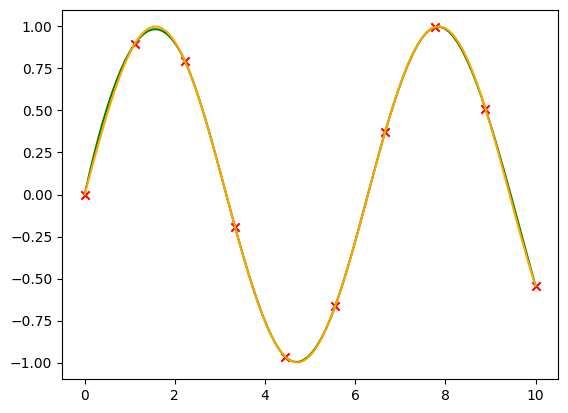

In [29]:
xs = np.linspace(0,10,size*10)

fig, ax = plt.subplots() 
ax.scatter(x1,y1, c='red', marker='x')
ax.plot(xs, cs(xs), c='green')
ax.plot(xs, np.sin(xs), c='orange')
plt.show()

In [7]:
def cubic_spline_interpol_x(x, f, i):
    # Values for v = v[i] 
    f_values = f[i,:] 
    spl = CubicSpline(x, f_values) #, bc_type='periodic')
    return spl

def build_x_interpolators(x, v, f):
    nv = len(v) 
    x_interpolators = [cubic_spline_interpol_x(x, f, i) for i in range(nv)] 
    return x_interpolators

def cubic_spline_interpol_v(v, f, j):
    # Values for x = x[j] 
    f_values = f[:,j] 
    spl = CubicSpline(v, f_values) #,  bc_type='periodic')
    return spl

def build_v_interpolators(x, v, f):
    nx = len(x) 
    v_interpolators = [cubic_spline_interpol_v(v, f, j) for j in range(nx)]
    return v_interpolators


## Code pour l'advection 

Afin d'imposer des conditions au bord périodiques, on effectue une disjonction de cas dans l'interpolation de la fonction $f$ selon si le point interpolé sort de la grille en $x$ ou en $v$ par la gauche ou par la droite. 

In [8]:
def local_x_advection(x, v, f, i, j, time_step, interpolators):
    _x = x[j]; _v = v[i] 
    x_tilde = _x - _v*time_step
    # Test cases to enforce periodic boundary conditions 
    if x_tilde < x[0]:
        # In case one steps out of the grid from the left 
        point = x[-1] - (x[0] - x_tilde) 
    elif x_tilde >= x[-1]:
        # In case one steps out of the grid from the right 
        point = x[0] + (x_tilde - x[-1])
    else:
        point = x_tilde 
    # interpolator for fixed v = v[i] 
    return interpolators[i](point) 

def local_v_advection(x, v, f, i, j, time_step, _E, interpolators):
    _x = x[j]; _v = v[i] 
    v_tilde = _v + _E[j]*time_step
    # Test cases for periodic boundary conditions 
    if v_tilde < v[0]:
        # In case one steps out of the grid from the left 
        point = v[-1] - (v[0] - v_tilde) 
    elif v_tilde >= v[-1]:
        # In case one steps out of the grid from the right 
        point = v[0] + (v_tilde - v[-1])
    else:
        point = v_tilde 
    # interpolator for fixed x = x[j] 
    return interpolators[j](point) 

def x_advection(x, v, f, time_step):
    nx = len(x) ; nv = len(v) 
    x_interpolators = build_x_interpolators(x, v, f)
    new_f = [local_x_advection(x, v, f, i, j, time_step, x_interpolators) 
        for i,j in np.ndindex((nv-1,nx-1))
    ]
    new_f = np.array(new_f)
    new_f.resize((nv-1,nx-1))
    new_f = np.append(new_f, np.zeros((nv-1, 1)), axis=1)
    new_f = np.append(new_f, np.zeros((1, nx)), axis=0) 
    # v periodic BC 
    new_f[-1,:] = new_f[0,:] 
    # x Periodic BC 
    new_f[:,-1] = new_f[:,0] 
    return new_f 

def v_advection(x, v, f, time_step, _E):
    nx = len(x) ; nv = len(v) 
    v_interpolators = build_v_interpolators(x, v, f) 
    new_f = [local_v_advection(x, v, f, i, j, time_step, _E, v_interpolators) 
        for i,j in np.ndindex((nv-1,nx-1))
    ]
    new_f = np.array(new_f)
    new_f.resize((nv-1, nx-1))
    new_f = np.append(new_f, np.zeros((nv-1, 1)), axis=1)
    new_f = np.append(new_f, np.zeros((1, nx)), axis=0) 
    # v periodic BC 
    new_f[-1,:] = new_f[0,:]
    # x Periodic BC 
    new_f[:,-1] = new_f[:,0]
    return new_f

In [32]:
f_one  = x_advection(x, v, f_zero, dt) 
f_two = v_advection(x, v, f_zero, 0.5*dt, _E_zero) 

/home/murloc/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:946: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.ascontiguousarray(x.ravel(), dtype=np.float_)


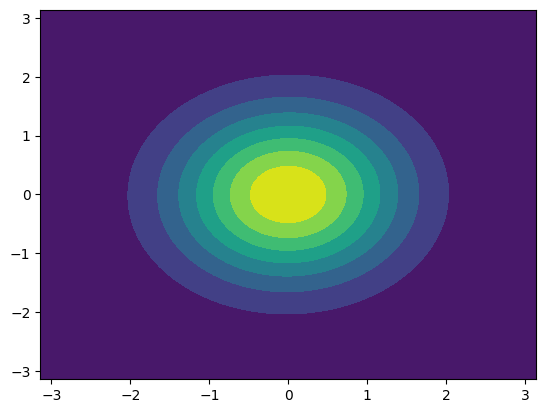

In [33]:
plt.contourf(x, v, f_one) 

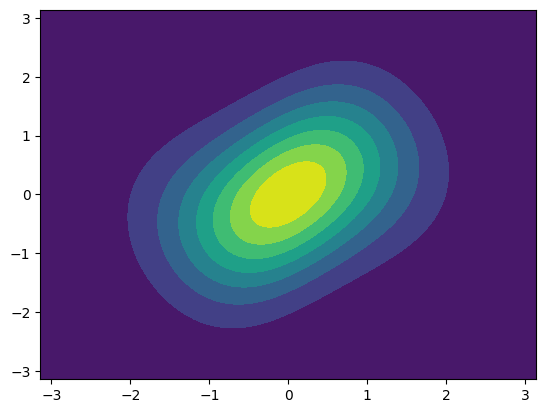

In [34]:
plt.contourf(x, v, f_two) 

## Schéma de Splitting semi-lagrangien

Nous détaillons ici le schéma de splitting que nous allons mettre en place pour la résolution du système de Vlasov-Poisson. 

1. $\textbf{Initialisation}$ : On se donne une condition initiale $f_0$, avec laquelle on calcule le champ initial $E_0$ en résolvant $(\text{P})$
2. $\textbf{Itération}$ : 
    - A partir de $(E^n, \,f^n)$ calculés à l'étape $n$ on calcule l'advection en $v$ sur un demi pas de temps $f^*(x,v) = f^n(x, v + E^n(x)\,\frac{\Delta t}{2})$ qui est solution de
        $$ \partial_t f - E^n(x)\,\partial_v f = 0.$$
        Les valeurs de $f^*$ étant obtenues par interpolation de $f^n$ selon la dimension $v$ en splines cubiques.

    - A partir de $f^*$ on calcule l'advection en $x$ sur un pas de temps complet $f^{**}(x,v) = f^*(x - v\,\Delta t, v)$ qui est solution de 
        $$ \partial_t f + v \,\partial_x f = 0.$$ 
        Les valeurs de $f^{**}$ étant également obtenues par interpolation de $f^{*}$ selon la dimension $x$ en splines cubiques.

    - On calcule le nouveau champ électrique $E^{n+1}(x)$ en résolvant $(\text{P})$ à partir de la distribution $f^{**}$.
    
    - Enfin, on effectue une dernière advection également avec une étape d'interpolation en splines cubiques en $v$ à partir du nouveau champ électrique et de $f^{**}$ pour obtenir $f^{n+1}(x,v) = f^{**}(x, v+E^{n+1}(x)\,\frac{\Delta t}{2})$ qui est solution de 
        $$ \partial_t f - E^{n+1}(x)\,\partial_v f = 0.$$ 
    
    - On stocke $(f^{n+1}, \,E^{n+1})$.


## Version du code en programmation objet 

In [9]:
class semi_lagrangian_solver():

    def __init__(self, nx, nv, dt, L):
        self.dt = dt 
        self.nx = nx 
        self.nv = nv
        self.L = L 
        self.x = np.linspace(-L, L, nx)
        self.v = np.linspace(-L, L, nv)  
        self._E = None 
        self.f_zero = None 
        self.f = None 
        self.solutions = []
        self.electric_fields = [] 

    def initialisation(self, f):
        xx, vv = np.meshgrid(self.x, self.v)
        self.f_zero = f(xx, vv)   
        _E_zero = solve_poisson(self.x, self.v, self.f_zero) 

        ## TO DELETE, TESTS FOR E 
        # _E_zero = np.random.random(nx) 
        #########################

        self._E = _E_zero 
        self.f = self.f_zero 
        self.solutions.append(self.f_zero)
        self.electric_fields.append(_E_zero)

    def solve(self, n_steps):  
        for i in range(n_steps):
            f_star = v_advection(self.x, self.v, self.f, 0.5*self.dt, self._E)
            f_star_two = x_advection(self.x, self.v, f_star, self.dt) 

            ## TO DELETE ONLY X ADVECTION 
            # f_star_two = x_advection(self.x, self.v, self.f, self.dt) 
            ##############################

            ## TO DELETE : TESTS ON E 
            # new_E = self._E
            #########################

            new_E = solve_poisson(self.x, self.v, f_star_two)
            new_f = v_advection(self.x, self.v, f_star_two, 0.5*self.dt, new_E) 

            ## TO DELETE : ONLY X ADVECTION
            new_f = f_star_two
            ###############################

            self.f = new_f 
            self._E = new_E
            self.solutions.append(new_f) 
            self.electric_fields.append(new_E)
    
    def save_solutions(self, dir):
        for i, f in enumerate(self.solutions):
            plt.contourf(self.x, self.v, f)
            plt.xlabel(r'$x$'); plt.ylabel(r'$v$') 
            plt.title(r"$f$ at t={} s".format(i*self.dt))
            plt.savefig(dir + "f_{:03d}.png".format(i)) 

    def save_electric_field(self, dir): 
        for i, _E in enumerate(self.electric_fields):
            plt.plot(self.x, _E)
            plt.xlabel(r'$x$')
            plt.title(r"$E$ at t={}s".format(i*self.dt))
            plt.savefig(dir + "E_{:03d}.png".format(i))
    
    def track_dominant_fourier_mode(self): 
        self.dominant_mode = [] 
        for _E in self.electric_fields:
            c = np.abs(np.fft.fft(_E)) 
            c.sort() 
            self.dominant_mode.append(c[-1]) 
        

In [139]:
solver = semi_lagrangian_solver(nx=100, nv=100, dt=1e-2, L=np.pi) 
solver.dt

0.01

In [140]:
solver.initialisation(f)

In [42]:
n = 1000

In [142]:
solver.solve(n_steps=n)  

In [143]:
solver.track_dominant_fourier_mode() 

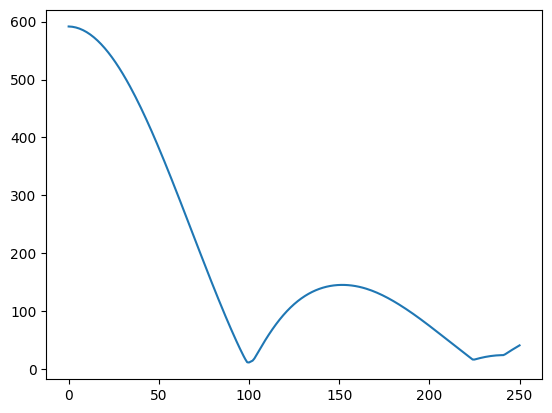

In [144]:
plt.plot(solver.dominant_mode) 

In [48]:
writergif = animation.PillowWriter(fps=10)

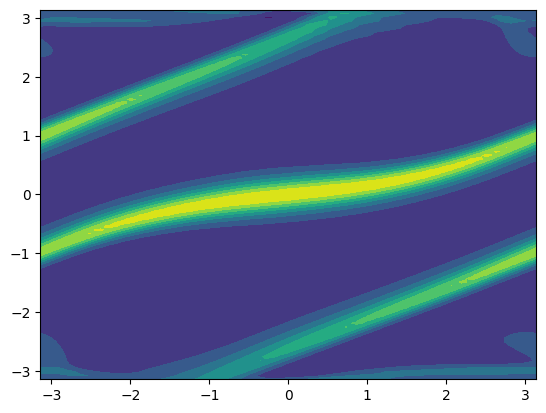

In [147]:
fig, ax = plt.subplots() 

def animate(i):
    ax.clear() 
    ax.contourf(solver.x, solver.v, solver.solutions[i])
    return 

anim = animation.FuncAnimation(fig, animate, frames=n, interval=200, repeat=True)  
anim.save('distrib_maxwell_n=200.gif', writer=writergif)
plt.show() 

## Test : Amortissement Landau 

L'amortissement Landau a lieu lorsque la condition initiale est un équilibre Maxwellien perturbé selon 

$$ f_0(x,v) = (1 + 0.001\cos(kx))\,\frac{1}{\sqrt{2\pi}}\,e^{-\frac{v^2}{2\sigma^2}}$$

In [37]:
sigma = 0.3

In [38]:
f_landau = lambda x,v : (1+0.001*np.cos(x)) * (1/(2*np.pi)**0.5) * np.exp(-0.5 * sigma**-2 * v**2)

In [39]:
solver_landau = semi_lagrangian_solver(nx=100, nv=100, dt=1e-2, L=np.pi)
solver_landau.initialisation(f_landau)

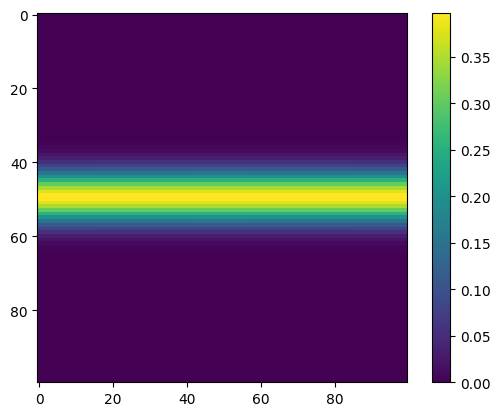

In [40]:

plt.imshow(solver.f_zero)
plt.colorbar() 

In [41]:
n = 4000

In [42]:
solver_landau.solve(n_steps=n)

/home/murloc/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:946: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.ascontiguousarray(x.ravel(), dtype=np.float_)


In [43]:
solver_landau.track_dominant_fourier_mode() 

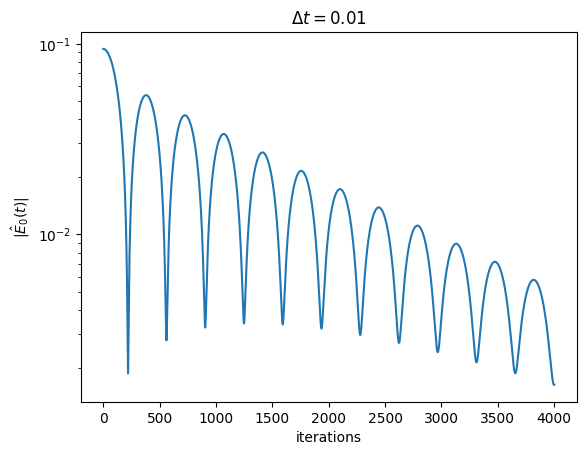

In [45]:
fig, ax = plt.subplots() 

plt.title(r'$\Delta t=0.01$')

ax.set_yscale('log')
ax.plot(solver_landau.dominant_mode)
ax.set_ylabel(r'$|\hat{E}_{0}(t)|$')
ax.set_xlabel('iterations') 

plt.savefig('./graphs/landau/fourier_mode.png')

In [164]:
fig, ax = plt.subplots() 

def animate(i):
    ax.clear() 
    ax.contourf(solver_landau.x, solver_landau.v, solver_landau.solutions[i])
    return 

anim = animation.FuncAnimation(fig, animate, frames=n, interval=200, repeat=True)  
anim.save('distrib_landau_n={}.gif'.format(n), writer=writergif)
plt.show() 

## Test : Instabilité double faisceau 

Soient deux faisceaux se déplaçant autour d'une vitesse moyenne $v_0$ et $-v_0$ respectivement. On considère la condition initiale 

$$ f_0(x,v) = (1 + 0.001\cos(kx))\,\frac{1}{2\sqrt{2\pi}}\,\left(e^{-\frac{(v-v_0)^2}{2\sigma^2}} + e^{- \frac{(v+v_0)^2}{2\sigma^2}}\right) $$ 

L'évolution est instable pour certaines valeurs de $k$ et de $v_0$. 

In [47]:
k = 0.5; v_0 = 0.9
sigma = 0.25

In [48]:
sigma**-2

16.0

In [49]:
f_instability = lambda x,v : (1+0.001*np.cos(k*x)) * (1/(2*sigma*(2*np.pi)**0.5)) * (np.exp(-0.5 * sigma**-2 * (v-v_0)**2) + np.exp(-0.5 * sigma**-2 * (v+v_0)**2))

In [60]:
solver_instability = semi_lagrangian_solver(nx=100, nv=100, dt=1e-2, L=np.pi) 
solver_instability.initialisation(f_instability)

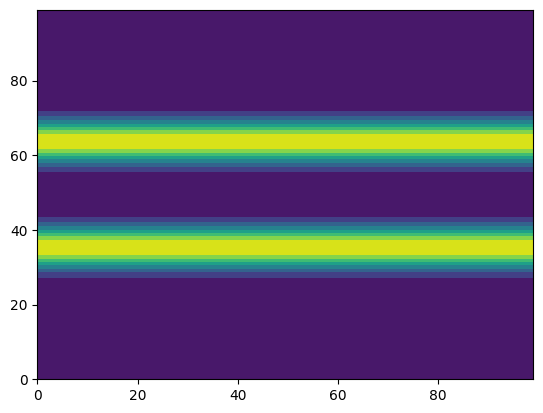

In [61]:
plt.contourf(solver_instability.f_zero)

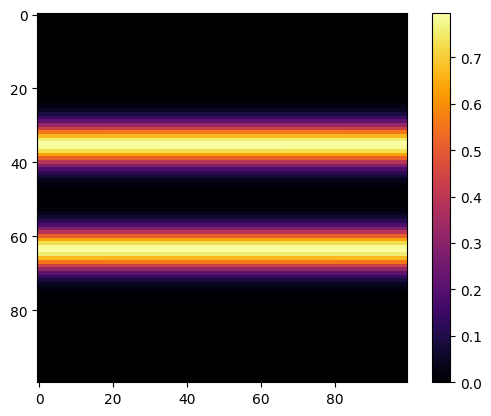

In [62]:
plt.imshow(solver_instability.f_zero, cmap='inferno') 
plt.colorbar()

In [63]:
n = 4000 

In [64]:
solver_instability.solve(n_steps=n)

/home/murloc/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:946: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.ascontiguousarray(x.ravel(), dtype=np.float_)


In [65]:
solver_instability.track_dominant_fourier_mode() 

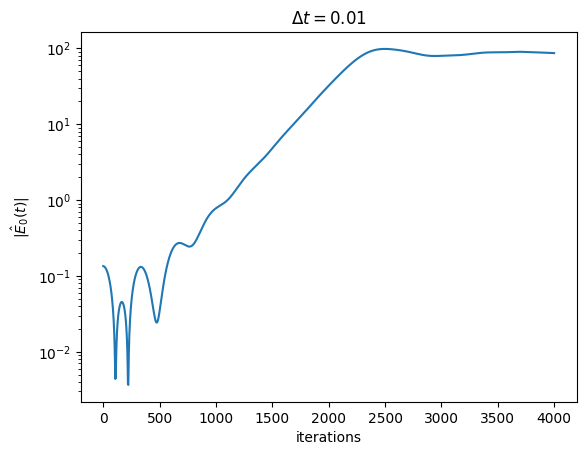

In [67]:
fig, ax = plt.subplots() 

plt.title(r'$\Delta t=0.01$')

ax.set_yscale('log')
ax.plot(solver_instability.dominant_mode)
ax.set_ylabel(r'$|\hat{E}_{0}(t)|$')
ax.set_xlabel('iterations') 

plt.savefig('./graphs/instability/fourier_mode.png')

In [21]:
writergif = animation.PillowWriter(fps=30) 

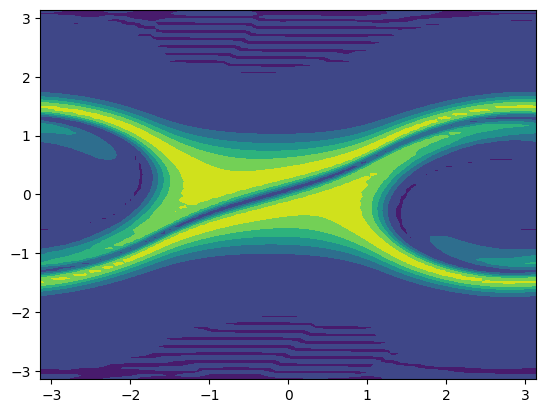

In [23]:
fig, ax = plt.subplots() 

def animate(i):
    ax.clear() 
    ax.contourf(solver.x, solver.v, solver.solutions[i])
    return 

anim = animation.FuncAnimation(fig, animate, frames=n, interval=200, repeat=True)  
anim.save('distrib_doublestream_n={}.gif'.format(n), writer=writergif)
plt.show() 